In [2]:
import xarray as xr
import proplot as pplt
import pandas as pd
from AOSCMcoupling.files import OIFSEnsemblePreprocessor, NEMOEnsemblePreprocessor
import numpy as np
from pathlib import Path
from ruamel.yaml import YAML

In [3]:
def vector_norm(x, dim, ord=None):
    return xr.apply_ufunc(
        np.linalg.norm, x, input_core_dims=[[dim]], kwargs={"ord": ord, "axis": -1}
    )

In [ ]:
output_dir = Path("../PAPA/ensemble_output_nomf")
oifs_preprocessor = OIFSEnsemblePreprocessor(pd.Timedelta(-7, "h"))
nemo_preprocessor = NEMOEnsemblePreprocessor(pd.Timedelta(-7, "h"))

In [6]:
experiment_directories = []
yaml = YAML(typ="unsafe", pure=True)
for date_dir in output_dir.glob("*"):
    if not date_dir.is_dir():
        continue
    with open(date_dir / "schwarz" / "setup_dict.yaml") as yaml_file:
        experiment = yaml.load(yaml_file)
        converged = (
            experiment["iterate_converged"]["2-norm"]
            and experiment["iterate_converged"]["inf-norm"]
        )
        if not converged:
            continue
    for experiment_dir in date_dir.glob("*"):
        experiment_directories.append(experiment_dir)

print(f"Number of Experiments: {int(len(experiment_directories) / 4)}")

progvars_ensemble = [
    experiment_dir / "progvar.nc" for experiment_dir in experiment_directories
]
nemo_t_ensemble = [
    next(experiment_dir.glob("*_grid_T*.nc"))
    for experiment_dir in experiment_directories
]

Number of Experiments: 112


In [7]:
colors = ["m", "c", "y", "k"]
cpl_schemes = ["parallel", "atm-first", "oce-first", "converged SWR"]
labels = ["parallel", "atmosphere-first", "ocean-first", "converged SWR"]
markers = [".", "x", "1", "+"]

# OpenIFS

In [8]:
prog_ensemble = xr.open_mfdataset(
    progvars_ensemble, preprocess=oifs_preprocessor.preprocess_ensemble
)
prog_forecast = prog_ensemble.isel(time=-1)
prog_forecast = prog_forecast.assign_coords(
    start_date=prog_forecast.start_date + prog_forecast.time
)
prog_forecast = prog_forecast.rename(start_date="end_date")

In [9]:
prog_forecast_diff = prog_forecast - prog_forecast.sel(coupling_scheme="converged SWR")

## Temperature in Boundary Layer

In [10]:
t_pbl_diff = prog_forecast_diff.t.sel(nlev=np.arange(51, 61))
t_pbl_diff = t_pbl_diff.drop_sel(coupling_scheme="converged SWR")
t_pbl_diff_l2 = vector_norm(t_pbl_diff.load(), "nlev", 2)
argmin_t_pbl_diff = t_pbl_diff_l2.argmin("coupling_scheme")

In [11]:
winner_count = argmin_t_pbl_diff.groupby(argmin_t_pbl_diff).count()
for index, cpl_scheme in enumerate(t_pbl_diff_l2.coupling_scheme.data):
    print(f"{cpl_scheme}: {int(winner_count[index])}")

atm-first: 54
oce-first: 43
parallel: 15


In [12]:
max_t_diff = float(t_pbl_diff.max().load())
print(f"e_max(T): {max_t_diff}")

e_max(T): 0.805267333984375


In [13]:
def get_group(label: str, grouped_array) -> list:
    coupling_schemes = ["atm-first", "oce-first", "parallel"]
    group = []
    for cpl_scheme in coupling_schemes:
        try:
            count = grouped_array[label].sel(coupling_scheme=cpl_scheme).shape[0]
        except KeyError:
            count = 0
        group.append(count)
    return group

In [14]:
t_diff_bins = [
    0.0,
    0.01 * max_t_diff,
    0.1 * max_t_diff,
    0.2 * max_t_diff,
    0.5 * max_t_diff,
    max_t_diff,
]
labels = ["A", "B", "C", "D", "E"]
grouped_t_diffs = t_pbl_diff_l2.groupby_bins(t_pbl_diff_l2, t_diff_bins, labels=labels)

groups = []
for label in labels:
    groups.append(get_group(label, grouped_t_diffs))
array = np.array(groups)

binned_t_diffs = xr.Dataset(
    {
        "t_error": (
            ("error_range", "coupling_scheme"),
            array,
        )
    },
    coords={
        "error_range": labels,
        "coupling_scheme": ["atmosphere-first", "ocean-first", "parallel"],
    },
)

## Humidity in Boundary Layer

In [15]:
q_pbl_diff = prog_forecast_diff.q.sel(nlev=np.arange(51, 61)) * 1e3
q_pbl_diff = q_pbl_diff.drop_sel(coupling_scheme="converged SWR")
q_pbl_diff_l2 = vector_norm(q_pbl_diff.load(), "nlev", 2)
argmin_q_pbl_diff = q_pbl_diff_l2.argmin("coupling_scheme")

In [16]:
winner_count = argmin_q_pbl_diff.groupby(argmin_q_pbl_diff).count()
for index, cpl_scheme in enumerate(q_pbl_diff_l2.coupling_scheme.data):
    print(f"{cpl_scheme}: {int(winner_count[index])}")

atm-first: 54
oce-first: 42
parallel: 16


In [17]:
max_q_diff = float(q_pbl_diff_l2.max().load())
print(f"e_max(q): {max_q_diff}")

e_max(q): 1.8152352571487427


In [18]:
q_diff_bins = [
    0.0,
    0.01 * max_q_diff,
    0.1 * max_q_diff,
    0.2 * max_q_diff,
    0.5 * max_q_diff,
    max_q_diff,
]
labels = ["A", "B", "C", "D", "E"]
grouped_q_diffs = q_pbl_diff_l2.groupby_bins(q_pbl_diff_l2, q_diff_bins, labels=labels)

groups = []
for label in labels:
    groups.append(get_group(label, grouped_q_diffs))
array = np.array(groups)

binned_q_diffs = xr.Dataset(
    {
        "q_error": (
            ("error_range", "coupling_scheme"),
            array,
        )
    },
    coords={
        "error_range": labels,
        "coupling_scheme": ["atmosphere-first", "ocean-first", "parallel"],
    },
)

# NEMO

In [19]:
nemo_ensemble = xr.open_mfdataset(
    nemo_t_ensemble, preprocess=nemo_preprocessor.preprocess_ensemble
)

In [20]:
nemo_forecast = nemo_ensemble.isel(time=-1)
nemo_forecast = nemo_forecast.assign_coords(
    start_date=nemo_forecast.start_date + nemo_forecast.time
)
nemo_forecast = nemo_forecast.rename(start_date="end_date")
sst_diff = np.abs(
    nemo_forecast - nemo_forecast.sel(coupling_scheme="converged SWR")
).sosstsst
sst_diff = sst_diff.drop_sel(coupling_scheme="converged SWR")
argmin_sst_diff = sst_diff.argmin("coupling_scheme")

In [21]:
winner_count = argmin_sst_diff.groupby(argmin_sst_diff).count()
for index, cpl_scheme in enumerate(sst_diff.coupling_scheme.data):
    print(f"{cpl_scheme}: {int(winner_count[index])}")

atm-first: 99
oce-first: 4
parallel: 9


In [22]:
max_sst_diff = float(sst_diff.max().load())
print(f"e_max(SST): {max_sst_diff}")

e_max(SST): 0.20120525360107422


In [23]:
sst_diff_bins = [
    0.0,
    0.01 * max_sst_diff,
    0.1 * max_sst_diff,
    0.2 * max_sst_diff,
    0.5 * max_sst_diff,
    max_sst_diff,
]
labels = ["A", "B", "C", "D", "E"]
grouped_sst_diffs = sst_diff.groupby_bins(sst_diff, sst_diff_bins, labels=labels)

groups = []
for label in labels:
    groups.append(get_group(label, grouped_sst_diffs))
array = np.array(groups)

binned_sst_diffs = xr.Dataset(
    {
        "sst_error": (
            ("error_range", "coupling_scheme"),
            array,
        )
    },
    coords={
        "error_range": labels,
        "coupling_scheme": ["atmosphere-first", "ocean-first", "parallel"],
    },
)

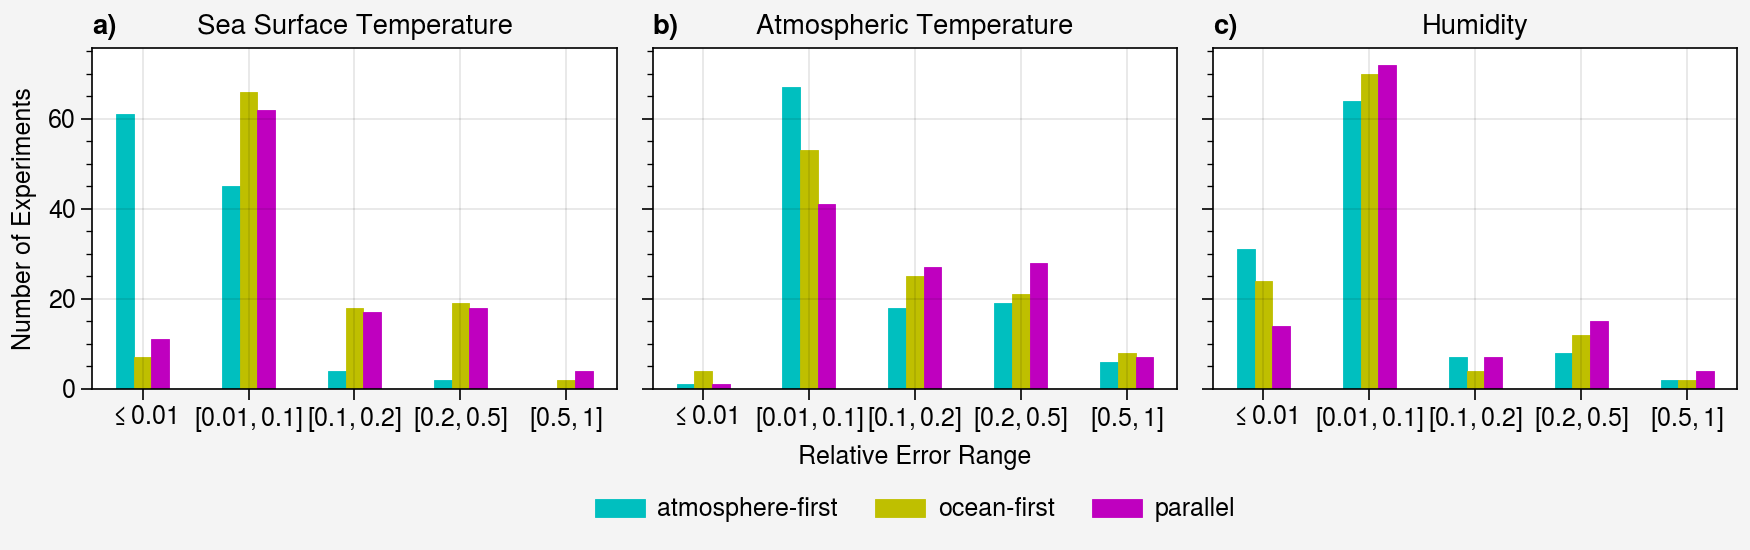

In [25]:
fig, axs = pplt.subplots(width="70em", height="22em", ncols=3)
cycle = pplt.Cycle(["c", "y", "m"])

ax = axs[0]
im = ax.bar(binned_sst_diffs.sst_error, cycle=cycle, width=0.5)
ax.format(
    xticklabels=[
        "$\leq 0.01$",
        "$[0.01, 0.1]$",
        "$[0.1, 0.2]$",
        "$[0.2, 0.5]$",
        "$[0.5, 1]$",
    ],
    ylabel="Number of Experiments",
    xlabel="Relative Error Range",
    title="Sea Surface Temperature",
)

ax = axs[1]
ax.bar(binned_t_diffs.t_error, cycle=cycle, width=0.5)
ax.format(
    xticklabels=[
        "$\leq 0.01$",
        "$[0.01, 0.1]$",
        "$[0.1, 0.2]$",
        "$[0.2, 0.5]$",
        "$[0.5, 1]$",
    ],
    ylabel="Number of Experiments",
    xlabel="Relative Error Range",
    title="Atmospheric Temperature",
)

ax = axs[2]
ax.bar(binned_q_diffs.q_error, cycle=cycle, width=0.5)
ax.format(
    xticklabels=[
        "$\leq 0.01$",
        "$[0.01, 0.1]$",
        "$[0.1, 0.2]$",
        "$[0.2, 0.5]$",
        "$[0.5, 1]$",
    ],
    ylabel="Number of Experiments",
    xlabel="Relative Error Range",
    title="Humidity",
)
axs.format(abc="a)")
fig.legend(im, frame=False, ncols=3, loc="b", title="")
fig.savefig("papa_2d_ensemble_nomf_relative_error_bar.png", dpi=300)